In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import TpotAutoml
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
pd.options.mode.chained_assignment = None

/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alirezafaghaninia/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/alirezafaghaninia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not

In [2]:
# user inputs:
SEED = 13
np.random.seed(SEED)
KEEP_ROWS_FRAC = 1.0 #0.05 # set to 1 if all rows are meant to be kept
skiprows_func = lambda i: i>0 and np.random.rand() > KEEP_ROWS_FRAC

In [3]:
usecols=['item_id', 'activation_date', 'city', 'region',
                              'parent_category_name', 'category_name', 
                             'item_seq_number', 'user_type', 'price_norm']

In [4]:
all_samples = pd.read_csv('data/all_samples_no_nulls.csv', usecols=usecols, skiprows=skiprows_func)

In [5]:
train = pd.read_csv('data/train.csv', usecols=['item_id', 'activation_date', 'deal_probability'])

In [6]:
all_samples.head()

,item_id,region,city,parent_category_name,category_name,item_seq_number,activation_date,user_type,price_norm
0,b912c3c6a6ad,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,2.0,2017-03-28,Private,-0.368621
1,2dac0150717d,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,19.0,2017-03-26,Private,0.170278
2,ba83aefab5dc,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,9.0,2017-03-20,Private,0.350379
3,02996f1dd2ea,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,286.0,2017-03-25,Company,0.288374
4,7c90be56d2ab,Волгоградская область,Волгоград,Транспорт,Автомобили,3.0,2017-03-16,Private,-0.803530


In [7]:
train = train.merge(all_samples, how='left', on=['item_id', 'activation_date'])

In [8]:
train = train.dropna()

In [9]:
train = train.sort_values(by='activation_date').drop('activation_date', axis=1).set_index('item_id')

In [10]:
train = pd.get_dummies(train)

In [11]:
target = 'deal_probability'
TIMEOUT_MINS = None
SCORING = 'r2'
X = (train.drop(target, axis=1)).values
y = train[target].values
tss = TimeSeriesSplit(n_splits=4)
train_index, test_index = list(tss.split(X))[-1]
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

config_dict = {'sklearn.ensemble.GradientBoostingRegressor': {
        'n_estimators': [100, 200, 400],
        'loss': ["ls", "lad", "huber", "quantile"],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'max_features': np.arange(0.05, 1.01, 0.05),
        'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    },
        'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': [100, 200, 400],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },
              }

tpot = TpotAutoml(mode='regression',
                  max_time_mins=TIMEOUT_MINS,
                  generations = 1, population_size=1,
                  scoring=SCORING,
                  random_state=SEED,
                  n_jobs=1,
                  verbosity=2,
                  cv=TimeSeriesSplit(n_splits=3),
                  config_dict=config_dict,                 
                 )

In [12]:
# base_model = GradientBoostingRegressor()
base_model = RandomForestRegressor()
# tpot = RandomizedSearchCV(estimator=base_model, random_state=RS,
# #                           param_distributions=config_dict['sklearn.ensemble.GradientBoostingRegressor'],
#                           param_distributions=config_dict['sklearn.ensemble.RandomForestRegressor'],
#                          n_iter=15,
#                          scoring='r2',
#                          cv=TimeSeriesSplit(n_splits=4),
#                          verbose=2,
#                          n_jobs=4)

tpot = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

In [13]:
tpot.fit(X_train, y_train)

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 45.2min


building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 207.1min


building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 268.4min finished


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

In [14]:
# feat_importance_entropy = list(zip(train.drop(target, axis=1).columns.values, tpot.best_estimator_.feature_importances_))
feat_importance_entropy = list(zip(train.drop(target, axis=1).columns.values, tpot.feature_importances_))

In [15]:
sorted(list(feat_importance_entropy), key=lambda x:x[1], reverse=True)[:10]

[('price_norm', 0.14535100147997626),
 ('parent_category_name_Личные вещи', 0.11479804742887222),
 ('item_seq_number', 0.10215752274522943),
 ('parent_category_name_Услуги', 0.08895697767185576),
 ('category_name_Предложение услуг', 0.08280025844802377),
 ('category_name_Одежда, обувь, аксессуары', 0.06665230839277253),
 ('category_name_Детская одежда и обувь', 0.04200329482420484),
 ('category_name_Товары для детей и игрушки', 0.037962425590185776),
 ('category_name_Автомобили', 0.021755137970076346),
 ('user_type_Private', 0.021206179343578723)]

In [16]:
test_score = tpot.score(X_test, y_test)
print(test_score)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.0s finished


0.17719105921764455


In [17]:
rmse = np.sqrt(np.mean((tpot.predict(X_test) - y_test) ** 2))
rmse

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.8s finished


0.23522198925263973

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.9s finished


0.14071674503963355
0.13809502820236524


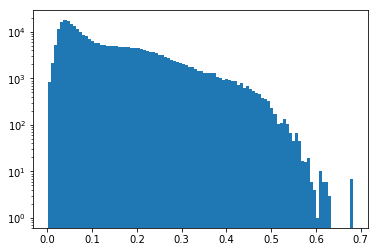

In [18]:
plt.hist(tpot.predict(X_test), log=True, bins=100)
print(tpot.predict(X_test).mean())
print(y_test.mean())

In [19]:
from analysis import Analysis
ea = Analysis(tpot, X_train, y_train, X_test, y_test,
                           mode='regression', target=target,
                           features=train.drop(target, axis=1).columns,
                           test_samples_index=test_index, random_state=SEED)

In [20]:
# ea.get_feature_importance(sort=True);

In [21]:
list(ea.feature_importance.items())[:10]

AttributeError: 'Analysis' object has no attribute 'feature_importance'

In [ ]:
# tpot.best_estimator_

In [24]:
test = pd.read_csv('data/test.csv', usecols=['item_id', 'activation_date'])
len(test)

508438

In [25]:
test = test.merge(all_samples, how='left', on=['item_id', 'activation_date'])
len(test)

508438

In [32]:
test = test.sort_values(by='activation_date').drop('activation_date', axis=1).set_index('item_id')

In [27]:
test = pd.get_dummies(test)

In [62]:
test_consistent = pd.DataFrame()
for feat in train.columns.values:
    if feat not in test:
        test_consistent.loc[:, feat] = [0.0]*len(test)
    else:
        test_consistent.loc[:, feat] = test[feat].values

In [77]:
test_consistent = test_consistent.set_index(test.index)

In [63]:
assert len(test_consistent.columns) == len(train.columns)

In [64]:
test_consistent = test_consistent.drop('deal_probability', axis=1)

In [65]:
test_consistent.head()

,item_seq_number,price_norm,region_Алтайский край,region_Башкортостан,region_Белгородская область,region_Владимирская область,region_Волгоградская область,region_Воронежская область,region_Иркутская область,region_Калининградская область,...,category_name_Спорт и отдых,category_name_Телефоны,category_name_Товары для детей и игрушки,category_name_Товары для животных,category_name_Товары для компьютера,category_name_Фототехника,category_name_Часы и украшения,user_type_Company,user_type_Private,user_type_Shop
0,59.0,0.432553,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.0,-0.024607,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,37.0,-0.069813,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,70.0,-0.609818,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,10.0,0.585951,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [66]:
test_consistent['deal_probability'] = tpot.predict(test_consistent.values)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    9.7s finished


In [67]:
import pickle
model_name = 'rf_tabular'
pickle.dump(tpot, open('saved_models/{}.pickle'.format(model_name), 'wb'))
model = pickle.load(open('saved_models/{}.pickle'.format(model_name), 'rb'))

In [78]:
test_consistent['deal_probability'][:2]

item_id
c4f49ffd12d7    0.204614
1ab4beda220b    0.040523
Name: deal_probability, dtype: float64

In [81]:
test_consistent['deal_probability'].reset_index().set_index('item_id').to_csv('predictions/tabular.csv')